In [1]:
# Useful starting lines ef
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# 1 Least squares and linear basis functions models
## 1.1 Least squares

In [2]:
def least_squares(y, tx):
    matrix1 = np.dot(tx.T,tx)
    matrix2 = np.dot(np.linalg.inv(matrix1),tx.T)
    weights = np.dot(matrix2,y)
    
    N = len(y)
    mse1 = (y - np.dot(tx,weights)).T
    mse2 = y - np.dot(tx,weights)
    mse = 1/2/N*np.dot(mse1,mse2) 
    return mse, weights

### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [3]:
from helpers import *
def test_your_least_squares():
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)
    mse,_ = least_squares(y,tx)
    return mse

Test it here

In [4]:
test_your_least_squares()

15.385887868829398

## 1.2 Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

In [5]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [6]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    N = len(x)
    matrix = np.zeros((N,degree+1))
    for i in range(0, N):
        for j in range(0, degree+1):
            matrix[i][j] = x[i]**j
    return matrix


Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

In [7]:
from costs import compute_mse
from plots import *

def polynomial_regression():

    degrees = [1, 3, 7, 12]
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    for ind, degree in enumerate(degrees):

        matrix = build_poly(x, degree)
        
        _,weights = least_squares(y, matrix)
        mse_poly = compute_mse(y, matrix, weights)
        rmse = np.sqrt(2*mse_poly)
        
        print("Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse))
        # plot fit
        plot_fitted_curve(
            y, x, weights, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()
    plt.savefig("visualize_polynomial_regression")
    plt.show()

Run polynomial regression

Processing 1th experiment, degree=1, rmse=0.47187607963421874
Processing 2th experiment, degree=3, rmse=0.25858277667737484
Processing 3th experiment, degree=7, rmse=0.24965870360908396
Processing 4th experiment, degree=12, rmse=0.9268294530625558


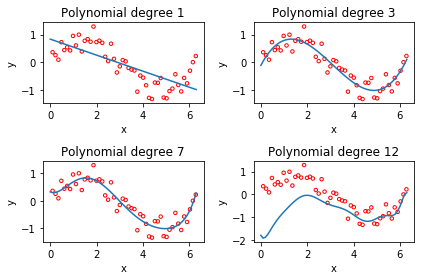

In [8]:
polynomial_regression()

# 2 Evaluating model predication performance


Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [96]:
def split_data(x, y, ratio, seed=1):

    np.random.seed(seed)
    
    shuffle_indices = np.random.permutation(np.arange(len(y)))
    shuffled_y = y[shuffle_indices]
    shuffled_x = x[shuffle_indices]
    
    x_train = shuffled_x[0:int(len(x)*ratio)]
    x_test = shuffled_x[int(len(x)*ratio):]
    
    y_train = shuffled_y[0:int(len(y)*ratio)]
    y_test = shuffled_y[int(len(y)*ratio):]    
    
    return x_train,x_test,y_train,y_test

Then, test your `split_data` function below.

In [85]:
def train_test_split_demo(x, y, degree, ratio, seed):

    x_train,x_test,y_train,y_test = split_data(x, y, ratio, seed)
    x_train_poly = build_poly(x_train, degree)    
    x_test_poly = build_poly(x_test, degree)

    _,weights_train = least_squares(y_train, x_train_poly)
    _,weights_test = least_squares(y_test, x_test_poly)

    mse_train = compute_mse(y_train, x_train_poly, weights_train)
    rmse_tr = np.sqrt(2*mse_train)
    
    mse_test = compute_mse(y_test, x_test_poly, weights_test)
    rmse_te = np.sqrt(2*mse_test)    

    print("proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
          p=ratio, d=degree, tr=rmse_tr, te=rmse_te))
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.5, 0.1]

for split_ratio in split_ratios:
    for degree in degrees:
        train_test_split_demo(x, y, degree, split_ratio, seed)

proportion=0.9, degree=1, Training RMSE=0.488, Testing RMSE=0.259
proportion=0.9, degree=3, Training RMSE=0.266, Testing RMSE=0.085
proportion=0.9, degree=7, Training RMSE=0.257, Testing RMSE=23.518
proportion=0.9, degree=12, Training RMSE=0.268, Testing RMSE=9.009
proportion=0.5, degree=1, Training RMSE=0.458, Testing RMSE=0.412
proportion=0.5, degree=3, Training RMSE=0.261, Testing RMSE=0.248
proportion=0.5, degree=7, Training RMSE=0.232, Testing RMSE=0.227
proportion=0.5, degree=12, Training RMSE=0.593, Testing RMSE=2.033
proportion=0.1, degree=1, Training RMSE=0.597, Testing RMSE=0.453
proportion=0.1, degree=3, Training RMSE=0.027, Testing RMSE=0.249
proportion=0.1, degree=7, Training RMSE=2.582, Testing RMSE=0.240
proportion=0.1, degree=12, Training RMSE=15.034, Testing RMSE=0.341


# 3 Ridge Regression
Please fill in the function below.

In [128]:
def ridge_regression(y, tx, lambda_):


    N = len(y)
    d = tx.shape[1]
    
    a = np.dot(tx.T, tx) + 2*N*lambda_*np.eye(d)
    b = np.dot(tx.T, y )
    w = np.linalg.solve(a,b)

    mse = compute_mse(y, tx, w) + lambda_*sum(w**2)
    return mse, w

In [129]:
def ridge_regression_demo(x, y, degree, ratio, seed):

    lambdas = np.logspace(-5, 0, 15)
    x_train, x_test, y_train, y_test = split_data(x, y, ratio, seed)

    x_train_poly = build_poly(x_train, degree)
    x_test_poly = build_poly(x_test, degree)

    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        mse_train, w = ridge_regression(y_train, x_train_poly, lambda_)
        rmse_tr.append(np.sqrt(mse_train*2))
        
        mse_test = compute_mse(y_test, x_test_poly, w) + lambda_*sum(w**2)
        rmse_te.append(np.sqrt(mse_test*2))
        print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
        
    # Plot the obtained results
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)



proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.337
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.228, Testing RMSE=0.337
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.228, Testing RMSE=0.336
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.229, Testing RMSE=0.335
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.230, Testing RMSE=0.335
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.233, Testing RMSE=0.332
proportion=0.5, degree=7, lambda=0.003, Training RMSE=0.236, Testing RMSE=0.324
proportion=0.5, degree=7, lambda=0.007, Training RMSE=0.243, Testing RMSE=0.311
proportion=0.5, degree=7, lambda=0.016, Training RMSE=0.255, Testing RMSE=0.298
proportion=0.5, degree=7, lambda=0.037, Training RMSE=0.273, Testing RMSE=0.300
proportion=0.5, degree=7, lambda=0.085, Training RMSE=0.295, Testing RMSE=0.326
proportion=0.5, degree=7, lambda=0.193, 

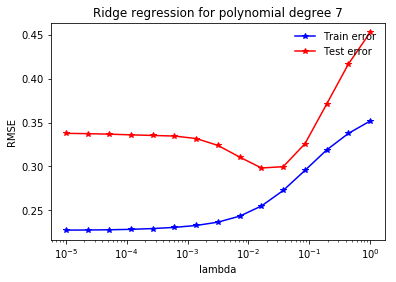

In [130]:
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)